In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dataprocessor

In [2]:
dict_kinect, bones_kinect = dataprocessor.kinect_dict_data("G3-Kinect-RTK-P1T1-Unknown-C-0.txt")
dict_vicon, bones_vicon = dataprocessor.vicon_dict_data("G3-Vicon-RTK-P1T1-Unknown-C-0.txt")


kinect_rh = dict_kinect['HandRight']
vicon_rh = dict_vicon['Right Hand']
kinect_lh = dict_kinect['HandLeft']
vicon_lh = dict_vicon['Left Hand']


kinect_rs = dict_kinect['ShoulderRight']
vicon_rs = dict_vicon['Right Shoulder']
kinect_ls = dict_kinect['ShoulderLeft']
vicon_ls = dict_vicon['Left Shoulder']
kinect_c = dict_kinect['SpineBase']
vicon_c = dict_vicon['Hips']
kinect_h = dict_kinect['Head']
vicon_h = dict_vicon['Head']
kinect_rf = dict_kinect['FootRight']
vicon_rf = dict_vicon['Right Foot']
kinect_lf = dict_kinect['FootLeft']
vicon_lf = dict_vicon['Left Foot']




kinect_data = [kinect_rs, kinect_ls, kinect_c, kinect_h, kinect_rf, kinect_lf, kinect_rh, kinect_lh]
vicon_data = [vicon_rs, vicon_ls, vicon_c, vicon_h, vicon_rf, vicon_lf, vicon_rh, vicon_lh]



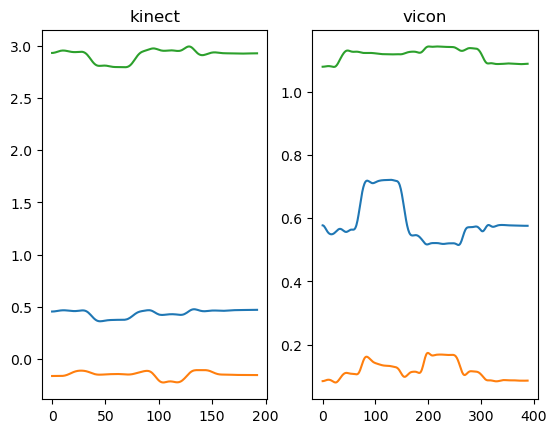

In [3]:
cut_off, sampling, order = 2, 30, 4

for kinect in kinect_data:
    for column in range(kinect.shape[1]):
        kinect[:, column] = dataprocessor.apply_butterworth_lowpass_filter(kinect[:, column], cut_off, sampling, order)

for vicon in vicon_data:
    for column in range(vicon.shape[1]):
        vicon[:, column] = dataprocessor.apply_butterworth_lowpass_filter(vicon[:, column], cut_off, sampling, order)


for index, kinect in enumerate(kinect_data):
    kinect_resampled = dataprocessor.resample_signal(kinect, original_sr=30, target_sr=60)
    kinect_data[index], vicon_data[index] = dataprocessor.make_length_similar(kinect_resampled, vicon_data[index])

  
plt.subplot(121)
plt.plot(kinect_rs[:, 0:3])
plt.title('kinect')

plt.subplot(122)
plt.plot(vicon_rs[:, 0:3])
plt.title('vicon')

plt.show()

## Finding rigid transformation between kinect and vicon's frame
### R, t = rigid_transform_3D(kinect, vicon)
### vicon = R * kinect + t
### so R states vectors in Vicons Frame

In [4]:
# kinect_trans = [kinect_data[-1], kinect_data[-2]]
# vicon_trans = [vicon_data[-1], vicon_data[-2]]
kinect_trans = kinect_data
vicon_trans = vicon_data

kinect_stacked = np.concatenate(kinect_trans, axis=0)
vicon_stacked = np.concatenate(vicon_trans, axis=0)
kinect_stacked.shape, vicon_stacked.shape 
R, t = dataprocessor.rigid_transform_3D(kinect_stacked[:, 0:3].T, vicon_stacked[:, 0:3].T)
# R = np.eye(3,3)
# t=0

In [5]:
from scipy.spatial.transform import Rotation 
r = Rotation.from_matrix(R)
r.as_euler('zyx', degrees=True)


array([ 131.48238848,  -80.55045819, -138.24507336])

In [6]:
for index, item in enumerate(kinect_data):
    in_ref_frame = R@item[:, :3].T+t
    kinect_data[index] = in_ref_frame.copy()

In [7]:
item.shape

(386, 7)

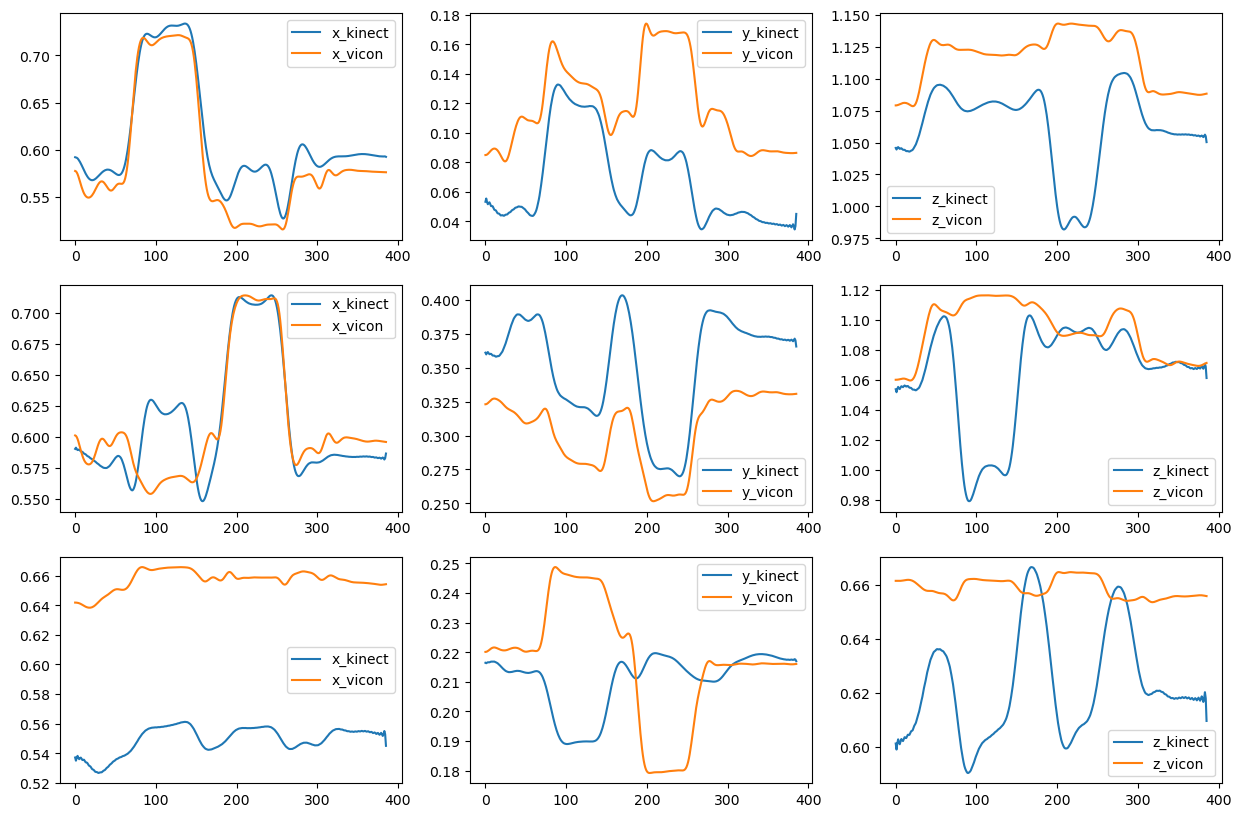

In [8]:
for c, item in enumerate(vicon_data):
    vicon_data[c] = item[:, :3].T.copy()
    

lbls_kin = ['x_kinect', 'y_kinect', 'z_kinect']
lbls_vic = ['x_vicon', 'y_vicon', 'z_vicon']
plt.figure(figsize=(15,10))
plt.subplot(333)
i = 1
offsets = np.zeros((3,3))
for index, item in enumerate(kinect_data[:3]):
    j = 0
    for row in range(3):
        plt.subplot(3,3,i)
        plt.plot(item[row, :], label = lbls_kin[row])
        plt.plot(vicon_data[index][row, :], label = lbls_vic[row])
        plt.legend()
        offsets[index, j] = item[row, 0] - vicon_data[index][row, 0]
        i += 1    
        j+=1
plt.show()

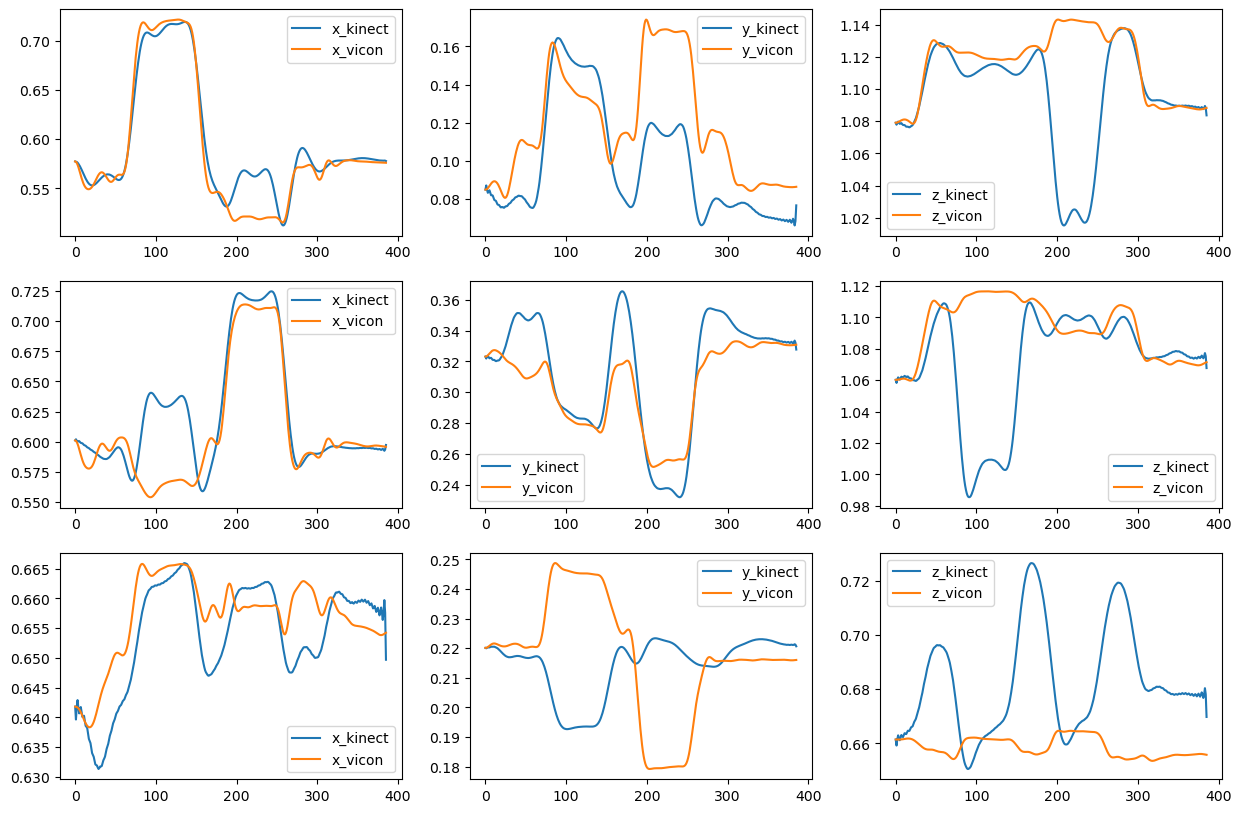

In [9]:
lbls_kin = ['x_kinect', 'y_kinect', 'z_kinect']
lbls_vic = ['x_vicon', 'y_vicon', 'z_vicon']
plt.figure(figsize=(15,10))
plt.subplot(333)
i = 1
for index, item in enumerate(kinect_data[:3]):
    j = 0
    for row in range(3):
        plt.subplot(3,3,i)
        item[row, :] -=  offsets[index, j]
        plt.plot(item[row, :], label = lbls_kin[row])
        plt.plot(vicon_data[index][row, :], label = lbls_vic[row])
        plt.legend()
        offsets[index, j] = item[row, 0] - vicon_data[index][row, 0]
        i += 1    
        j+=1
plt.show()

In [10]:
def create_body_frame(p1, p2, p3):
    
    '''creates a body frame from coordinates of 3 points of a rigid body '''
    u = p2 - p1
    i_hat = u/np.linalg.norm(u, axis=0)
    v = p3 - p1
    cps = np.cross(i_hat, v, axisa=0, axisb=0, axisc=0)
    j_hat = cps/np.linalg.norm(cps, axis=0)

    k_hat = np.cross(i_hat, j_hat, axisa=0, axisb=0, axisc=0)
    
    return i_hat, j_hat, k_hat

def find_euler_from_uv(p1, p2, p3):  

    i_hat, j_hat, k_hat = create_body_frame(p1, p2, p3)
    psi = np.zeros(i_hat.shape[1]) # Presicion
    theta = np.zeros_like(psi) # Nutation
    phi = np.zeros_like(psi) # Spin

    for time in range(i_hat.shape[1]):
        r = Rotation.from_matrix(np.array([i_hat[:, time], j_hat[:, time], k_hat[:, time]]))
        rot_values = r.as_euler('xyx', degrees=True)
        psi[time], theta[time], phi[time] = rot_values[0], rot_values[1], rot_values[2]
        
    return psi, theta, phi, r
        

In [11]:
# R_tktv = ???
i_hat_tk, j_hat_tk, k_hat_tk,_ = find_euler_from_uv(kinect_data[2], kinect_data[0], kinect_data[1])
i_hat_tv, j_hat_tv, k_hat_tv,_ = find_euler_from_uv(vicon_data[2], vicon_data[0], vicon_data[1])

# R_tktv = Rotation.from_matrix(np.array([]))



psi_kin, theta_kin, phi_kin, r_tk0 = find_euler_from_uv(kinect_data[2], kinect_data[0], kinect_data[1])
psi_vic, theta_vic, phi_vic, r_tv0 = find_euler_from_uv(vicon_data[2], vicon_data[0], vicon_data[1])
# r_tvtk = np.linalg.inv(r_tk0) @ r_tv0

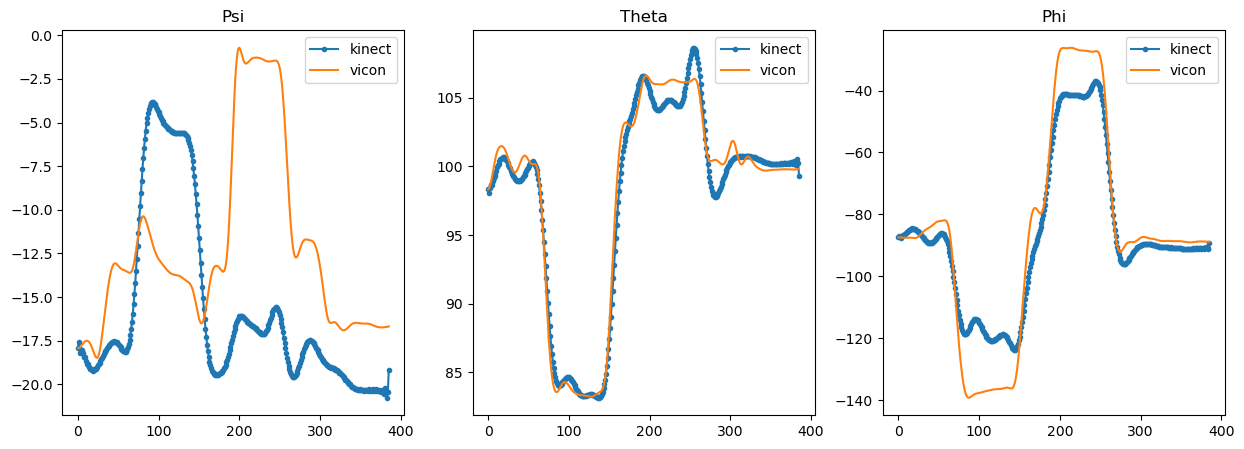

In [12]:
plt.figure(figsize=(15,5))
titles = ['Psi', 'Theta', 'Phi'] 
plt.subplot(131)
kin_rots = [psi_kin, theta_kin, phi_kin]
vic_rots = [psi_vic, theta_vic, phi_vic]
for i in range(3):
    plt.subplot(1, 3,i+1)
    plt.plot(kin_rots[i], '.-',label ='kinect')
    plt.plot(vic_rots[i], label ='vicon')
    plt.legend()
    plt.title(titles[i])    

plt.show()

In [13]:
u = kinect_data[0] - kinect_data[2] # rs - c
i_hat = u/np.linalg.norm(u, axis=0)
v = kinect_data[1] - kinect_data[2] # ls - c
cps = np.cross(i_hat, v, axisa=0, axisb=0, axisc=0)
j_hat = cps/np.linalg.norm(cps, axis=0)

k_hat = np.cross(i_hat, j_hat, axisa=0, axisb=0, axisc=0)
# u.shape, v.shape
 

In [14]:
j_hat[:, 0]

array([-0.98840355,  0.0877368 , -0.12393823])

In [15]:
def determine_time_shift(signal1, signal2):
    # Calculate the cross-correlation between the two signals
    cross_corr = np.correlate(signal1, signal2, mode='full')
    
    # Find the index corresponding to the maximum cross-correlation value
    max_index = np.argmax(cross_corr)
    
    # Determine the time shift estimate
    time_shift_estimate = max_index - (len(signal2) - 1)
    
    return time_shift_estimate

def align_signals(signal1, signal2):
    time_shift = determine_time_shift(signal1, signal2)
    
    if time_shift > 0:
        signal1_aligned = signal1[time_shift:]
        signal2_aligned = signal2[:len(signal2)-time_shift]
    else:
        signal1_aligned = signal1[:len(signal1)+time_shift]
        signal2_aligned = signal2[-time_shift:]
    
    return signal1_aligned, signal2_aligned


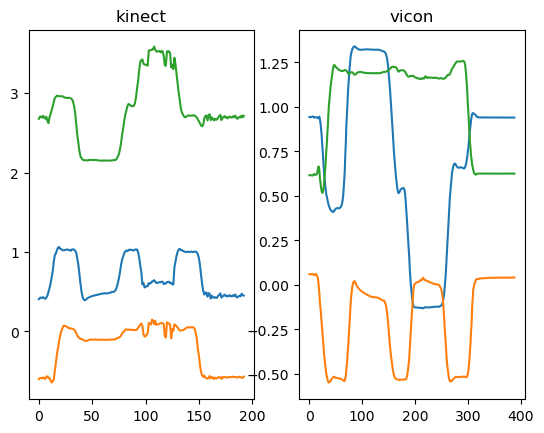

In [16]:
dict_kinect, bones_kinect = dataprocessor.kinect_dict_data("G3-Kinect-RTK-P1T1-Unknown-C-0.txt")
dict_vicon, bones_vicon = dataprocessor.vicon_dict_data("G3-Vicon-RTK-P1T1-Unknown-C-0.txt")

kinect = dict_kinect['HandRight']
vicon = dict_vicon['Right Hand']

plt.subplot(121)
plt.plot(kinect[:, 0:3])
plt.title('kinect')

plt.subplot(122)
plt.plot(vicon[:, 0:3])
plt.title('vicon')

plt.show()

(193, 7)


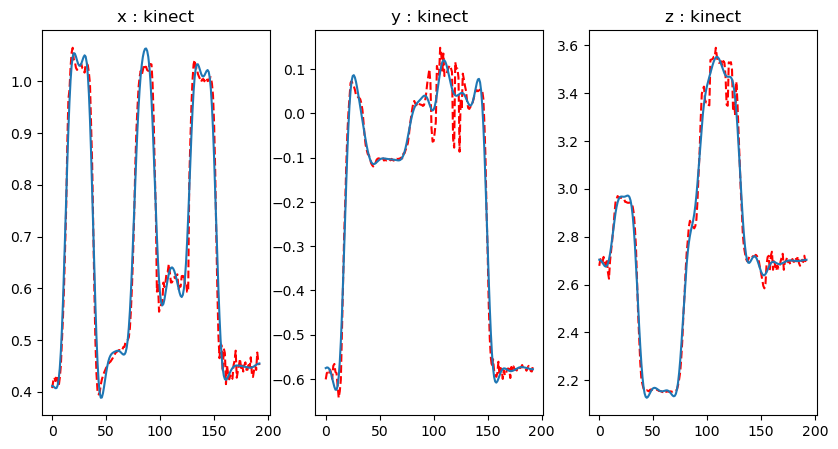

In [17]:
cut_off, sampling, order = 2, 30, 4
filtered_kinect = np.zeros_like(kinect)

print(filtered_kinect.shape)

for column in range(kinect.shape[1]):
    filtered_kinect[:, column] = dataprocessor.apply_butterworth_lowpass_filter(kinect[:, column], cut_off, sampling, order)

plt.figure(figsize=(10,5))
plt.subplot(131)
plt.plot(kinect[:, 0], '--r')
plt.plot(filtered_kinect[:, 0])
plt.title('x : kinect')

plt.subplot(132)
plt.plot(kinect[:, 1], '--r')
plt.plot(filtered_kinect[:, 1])
plt.title('y : kinect')

plt.subplot(133)
plt.plot(kinect[:, 2], '--r')
plt.plot(filtered_kinect[:, 2])
plt.title('z : kinect')

plt.show()

In [18]:
filtered_resampled_kinect = dataprocessor.resample_signal(filtered_kinect, original_sr=30, target_sr=60)
filtered_resampled_kinect, vicon = dataprocessor.make_length_similar(filtered_resampled_kinect, vicon)
filtered_resampled_kinect.shape, vicon.shape

((386, 7), (386, 7))

In [19]:

filtered_resampled_kinect = filtered_resampled_kinect[:, 0:3]
filtered_resampled_kinect=filtered_resampled_kinect.T

kinect = R @ filtered_resampled_kinect + t
vicon = vicon[:, 0:3].T

kinect.shape, vicon.shape

((3, 386), (3, 386))

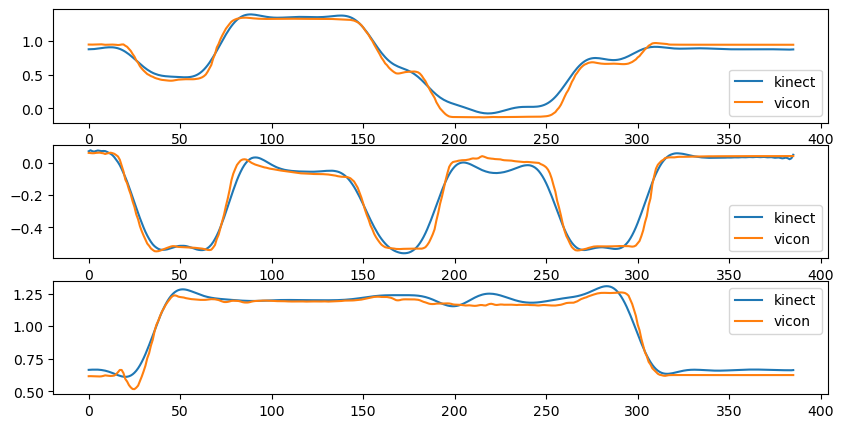

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(311)
plt.plot(kinect[0, :], label = 'kinect')
plt.plot(vicon[0, :], label = 'vicon')
plt.legend()


plt.subplot(312)
plt.plot(kinect[1, :], label = 'kinect')
plt.plot(vicon[1, :], label = 'vicon')
plt.legend()

plt.subplot(313)
plt.plot(kinect[2, :], label = 'kinect')
plt.plot(vicon[2, :], label = 'vicon')
plt.legend()
plt.show()

## Plotting Skeletons

In [21]:
for key in dict_kinect:
    for column in range(dict_kinect[key].shape[1]):
        dict_kinect[key][:, column] = dataprocessor.apply_butterworth_lowpass_filter(dict_kinect[key][:, column], cut_off, sampling, order)

for key in dict_vicon:
    for column in range(dict_vicon[key].shape[1]):
        dict_vicon[key][:, column] = dataprocessor.apply_butterworth_lowpass_filter(dict_vicon[key][:, column], cut_off, sampling, order)

for index, key in enumerate(dict_kinect):
    kinect_resampled = dataprocessor.resample_signal(dict_kinect[key], original_sr=30, target_sr=60)
    dict_kinect[key], _ = dataprocessor.make_length_similar(kinect_resampled, dict_vicon['Chest'])
    
dict_vicon.keys()


dict_keys(['Right Forearm', 'Left Forearm', 'Right Arm', 'Left Arm', 'Chest', 'Right Thigh', 'Left Thigh', 'Right Shoulder', 'Left Shoulder', 'Right Hand', 'Left Hand', 'Right Foot', 'Left Foot', 'Hips', 'Head', 'Right Tibia', 'Left Tibia'])

C:\Users\Ali\AppData\Local\Temp\ipykernel_19900\552209882.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-r" (-> color='r'). The keyword argument will take precedence.
  ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], '.-r',color='blue')


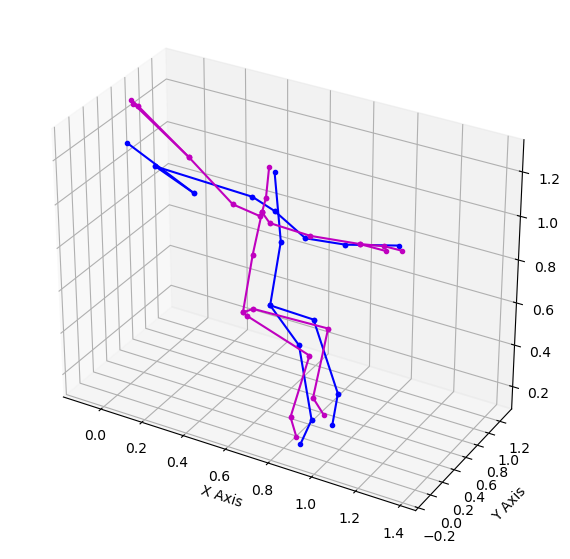

In [22]:
keys_vic = list(dict_vicon.keys())
keys_kin = list(dict_kinect.keys())
time = 80
fig = plt.figure(figsize = (10, 7))

ax = plt.axes(projection ="3d")

# ax.scatter(vicon_data[2][0,0], 
#            vicon_data[2][0,1],
#            vicon_data[2][0,2],
#            c='red', marker='*', s=1000)

# ax.set_xlim(0, 1)
# ax.set_ylim(-0.4, 0.8)
# ax.set_zlim(0.2, 1.4)
for time in range(time,time+1):
    for bone in bones_vicon:
        key_start = keys_vic[bone[0]]
        key_end = keys_vic[bone[1]]
        coords_start = dict_vicon[key_start][time, 0:3]
        coords_end = dict_vicon[key_end][time, 0:3]
        coords = np.vstack((coords_start, coords_end))
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], '.-r',color='blue')
        ax.axis('square')
        # ax.set_xlim(0.5, 1)
        # ax.set_ylim(-0.4, 0.8)
        # ax.set_zlim(0.2, 1.4)

# fig = plt.figure(figsize = (10, 7))

# ax = plt.axes(projection ="3d")        
# for time in range(time,time+1):    
    for bone in bones_kinect:
        key_start = keys_kin[bone[0]]
        key_end = keys_kin[bone[1]]
        coords_start = dict_kinect[key_start][time, 0:3]
        coords_end = dict_kinect[key_end][time, 0:3]
        coords = np.vstack((coords_start, coords_end))
        coords = (R@coords.T + t).T # want to each point be a row
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], '.-m')
        ax.axis('square')
        # ax.set_xlim(0.5, 1)
        # ax.set_ylim(-0.4, 0.8)
        # ax.set_zlim(0.2, 1.4)
        

        # ax.view_init(0, 0)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')


plt.show()


In [24]:
def dydt(y, dt):
    y = np.gradient(y)/(2*dt)
    y[0] *= 2
    y[-1] *= 2
    return y


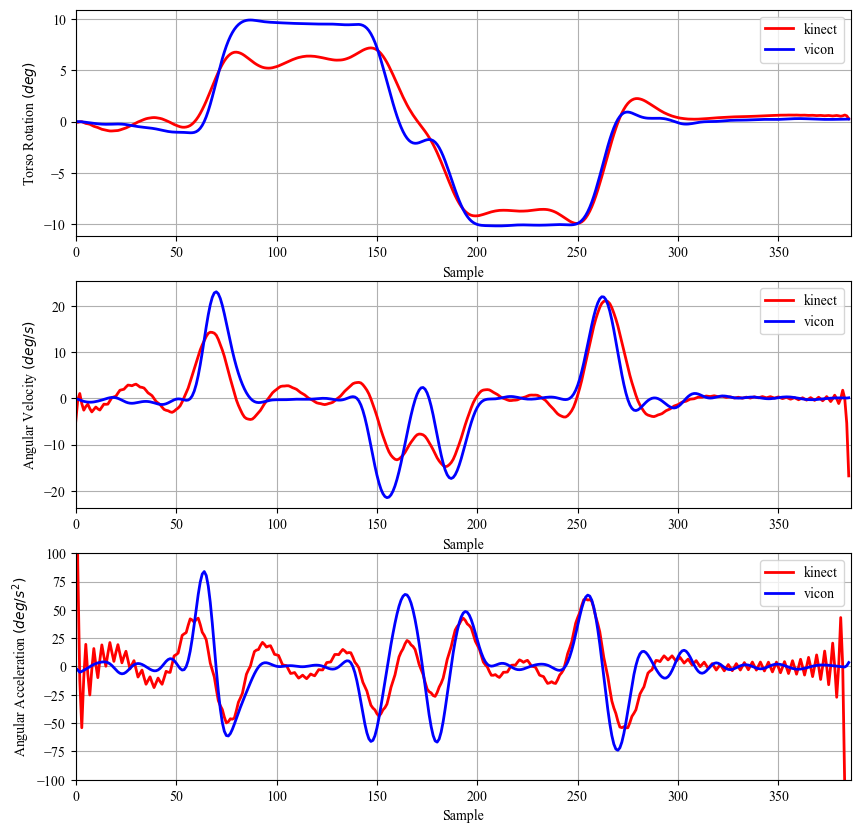

In [25]:
f_hat = j_hat[: ,0].copy()

s_hats_kinect = kinect_data[0] - kinect_data[1]
s_hats_vicon = vicon_data[0] - vicon_data[1]

rot_kinect = np.rad2deg(np.arccos(np.dot(f_hat.T, s_hats_kinect)))
rot_vicon = np.rad2deg(np.arccos(np.dot(f_hat.T, s_hats_vicon)))

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Times New Roman"
plt.subplot(311)
plt.plot(rot_kinect-90, label='kinect', color='r', linewidth=2)
plt.plot(rot_vicon-90, label='vicon', color='b', linewidth=2)
plt.legend()
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Torso Rotation $(deg)$')
plt.xlim(0, 386)

dt=1/60
vel_kinect=dydt(rot_kinect, dt)
vel_vicon = dydt(rot_vicon, dt)
plt.subplot(312)
plt.plot(vel_kinect, label='kinect', color='r', linewidth=2)
plt.plot(vel_vicon, label='vicon', color='b', linewidth=2)
plt.grid()
plt.legend()

plt.xlabel('Sample')
plt.ylabel('Angular Velocity $(deg/s)$')
plt.xlim(0, 386)

plt.subplot(313)
acc_kinect = dydt(vel_kinect, dt)
acc_vicon = dydt(vel_vicon, dt)

plt.plot(acc_kinect, label='kinect', color='r', linewidth=2)
plt.plot(acc_vicon, label='vicon', color='b', linewidth=2)
plt.grid()
plt.legend()

plt.xlabel('Sample')
plt.ylabel('Angular Acceleration $(deg/s^2)$')
plt.xlim(0, 386)
plt.ylim(-100, 100)

plt.show()



## Comparing signals

In [26]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr     

def compare_signals(sig1, sig2):
    rms = mean_squared_error(sig1, sig2, squared=False)
    range_actual = np.abs(max(sig1) - min(sig2))
    nrmse = rms / range_actual
    correlation, p_value = pearsonr(sig1, sig2)
    return rms,nrmse, correlation, p_value

import seaborn as sns
def bland_altman_plot(data1, data2, y_label,*args, **kwargs):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)

    sns.scatterplot(x=mean, y=diff, color='black')
    plt.axhline(md, color='gray', linestyle='-')
    plt.axhline(md + 1.96 * sd, color='red', linestyle='--')
    plt.axhline(md - 1.96 * sd, color='red', linestyle='--')
    plt.xlabel(f"Average of 2 measures {y_label}", fontname='Times New Roman')
    plt.ylabel(f"Difference between 2 measures {y_label}", fontname='Times New Roman')
    plt.text(plt.xlim()[1], diff.mean() + 1.96 * diff.std(), '+1.96*SD', ha='right', fontsize=12, color='red')
    plt.text(plt.xlim()[1], diff.mean() - 1.96 * diff.std(), '-1.96*SD', ha='right', fontsize=12, color='red')
    


In [27]:
rms_pos, nrms_pos, corr_pos, p_pos = compare_signals(rot_kinect, rot_vicon)
rms_pos, nrms_pos, corr_pos, p_pos

(1.745704725695791,
 0.10084473484820104,
 0.9689387192672576,
 4.186212993107336e-235)

In [28]:
rms_vel, nrms_vel, corr_vel, p_vel = compare_signals(vel_kinect, vel_vicon)
rms_vel, nrms_vel, corr_vel, p_vel


(3.95668742549665,
 0.09306684070026656,
 0.8351431337367783,
 9.918018149781563e-102)

In [29]:
rms_acc, nrms_acc, corr_acc, p_acc = compare_signals(acc_kinect, acc_vicon)
rms_acc, nrms_acc, corr_acc, p_acc

(44.1652090641504,
 0.12602179809095265,
 0.3369517978160544,
 1.0578546010356887e-11)

Text(0.5, 1.0, 'Bland Altman Plot for Torso Angular Acceleration')

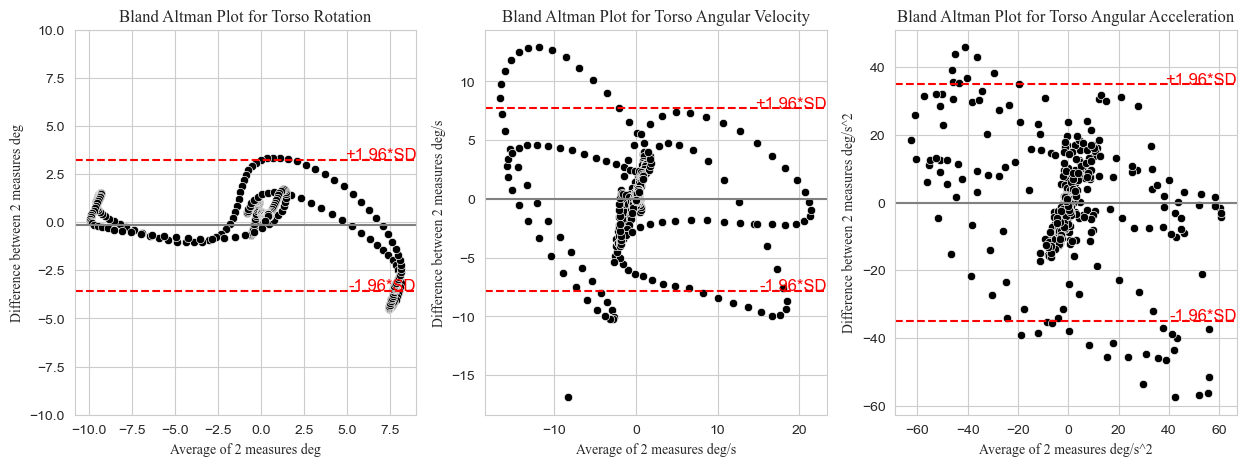

In [30]:
plt.figure(figsize=(15,5))
# sns.set_style("darkgrid")
sns.set_style("whitegrid")
plt.subplot(131)
bland_altman_plot(rot_kinect-90, rot_vicon-90, 'deg',marker='.', color='black')
plt.ylim(-10, 10)
plt.title('Bland Altman Plot for Torso Rotation',fontname='Times New Roman')
plt.subplot(132)
bland_altman_plot(vel_kinect, vel_vicon, 'deg/s',marker='.', color='black')
plt.title('Bland Altman Plot for Torso Angular Velocity',fontname='Times New Roman')

plt.subplot(133)
bland_altman_plot(acc_kinect[20:-20], acc_vicon[20:-20], 'deg/s^2', marker='.', color='black')
plt.title('Bland Altman Plot for Torso Angular Acceleration',fontname='Times New Roman')
